In [82]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
#In case I want to load data into colab itself
#!cp -r '../content/drive/My Drive/FSDKaggle2018.audio_train/' /content

In [0]:
#Importing libraries
import numpy as np 
import pandas as pd

import librosa 
import librosa.display

import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline
matplotlib.style.use('ggplot')

from python_speech_features import mfcc, logfbank
from scipy.io import wavfile

import os
import shutil
import warnings
warnings.filterwarnings('ignore')

In [0]:
#Reading meta data file
train = pd.read_csv('../content/drive/My Drive/esc50.csv')

In [0]:
#train = train.drop(['esc10', 'src_file', 'take', 'fold'], axis =1)

In [0]:
#train = train[['filename', 'category', 'target']]

In [108]:
train.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [97]:
print("Number of training examples=", train.shape[0], "  Number of classes=", 
      len(train['category'].unique()))

Number of training examples= 2000   Number of classes= 50


In [0]:
#train.category.value_counts()

### Checking for number of channels, bit depth and sample rates of files

In [0]:
import struct

class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [0]:
#from helpers.wavfilehelper import WavFileHelper
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in train.iterrows():
    
    file_name = os.path.join(os.path.abspath('/content/drive/My Drive/audio/'+wav_file))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [94]:
#num of channels 
print(audiodf.num_channels.value_counts(normalize=True))

1    1.0
Name: num_channels, dtype: float64


In [95]:
#sample rates 
print(audiodf.sample_rate.value_counts(normalize=True))

44100    1.0
Name: sample_rate, dtype: float64


In [96]:
#bit depth
print(audiodf.bit_depth.value_counts(normalize=True))

16    1.0
Name: bit_depth, dtype: float64


### Plotting times series, fourier transform and filter bank coefficients plots

In [0]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(3):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(3):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=3, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(3):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [0]:
classes = list(np.unique(train.category))

In [0]:
def calc_fft(y, rate):
  n = len(y)
  freq = np.fft.rfftfreq(n, d = 1/rate)
  Y = abs(np.fft.rfft(y)/n)
  return(Y, freq)

In [0]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

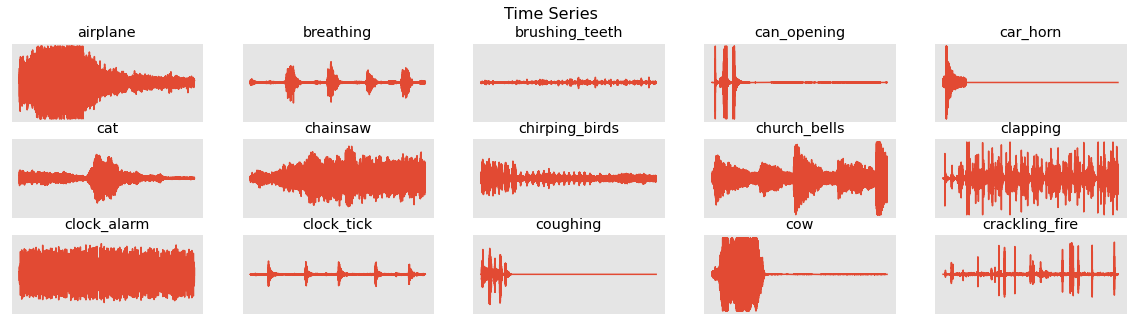

In [114]:
for c in classes: 
  wav_file = train[train.category == c].iloc[0,0]
  signal, rate = librosa.load('/content/drive/My Drive/audio/' +wav_file, sr = 44100)
  
  signals[c] = signal
  fft[c] = calc_fft(signal, rate)
  

  bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
  fbank[c] = bank
  #mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft= 1103).T
  #mfccs[c] = mel

plot_signals(signals)
plt.show();

#plot_mfcc(mfccs)
#plt.show()

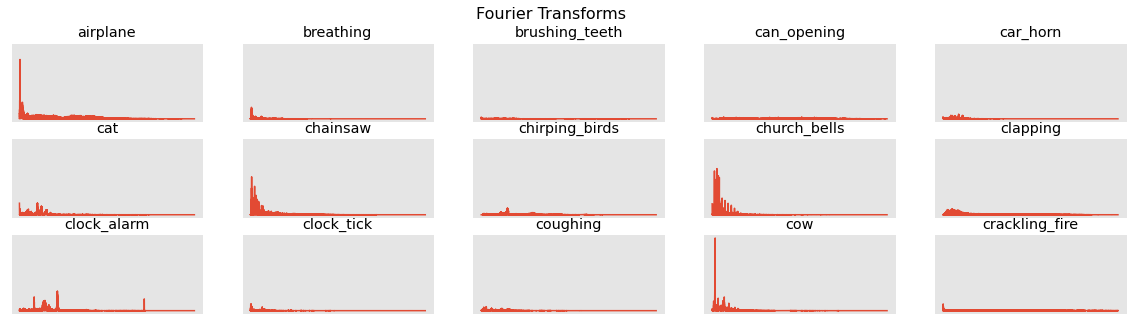

In [115]:
plot_fft(fft)
plt.show();

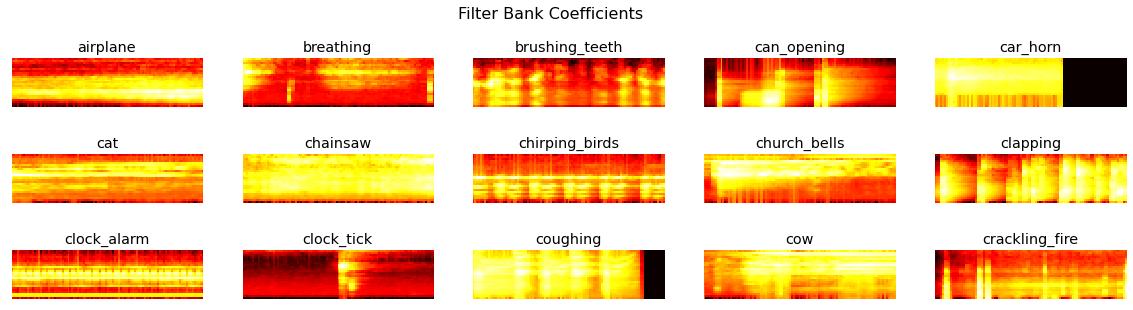

In [116]:
plot_fbank(fbank)
plt.show;

### Analysing Audio Data

In [98]:
# Using IPython.display.Audio to play the audio files so we can inspect aurally
ipd.Audio('../content/drive/My Drive/audio/1-7057-A-12.wav')

In [0]:
filename = '/content/drive/My Drive/audio/1-137-A-32.wav'

In [118]:
#Sample rate conversion
librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate)

Original sample rate: 44100
Librosa sample rate: 22050


In [119]:
#Bit depth conversion
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -17080 to 12341
Librosa audio file min~max range: -0.5164941 to 0.35505846
